# 02 - Preprocessing and Function Extraction

This notebook focuses on extracting individual functions from smart contracts and preparing clean, labeled datasets for machine learning.

**Goals:**
- Parse Solidity contracts and extract individual functions
- Map bug locations from CSV logs to specific functions
- Clean and normalize Solidity code
- Create function-level labeled datasets
- Handle different vulnerability types
- Generate training/validation splits
- Save processed datasets for model training

## 1. Import Libraries and Setup

In [1]:
import sys
import os
import re
import json
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict, Counter
from typing import List, Dict, Tuple, Optional

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# ML utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Utilities
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Libraries imported successfully!")
print(f"📁 Working directory: {os.getcwd()}")

✅ Libraries imported successfully!
📁 Working directory: /home/virtualvasu/Desktop/sem5/ml_project/smart-contract-vuln-detector/notebooks


## 2. Load Dataset Summary and Configuration

In [2]:
# Load dataset summary from previous notebook
with open('../data/processed/dataset_summary.json', 'r') as f:
    dataset_summary = json.load(f)

# Extract key information
vulnerability_categories = dataset_summary['overview']['vulnerability_categories']
total_contracts = dataset_summary['overview']['total_sol_files']

# Define paths
dataset_root = Path("../dataset")
buggy_contracts_dir = dataset_root / "buggy_contracts"
processed_data_dir = Path("../data/processed")
processed_data_dir.mkdir(exist_ok=True)

print("📊 DATASET CONFIGURATION")
print("=" * 40)
print(f"Vulnerability Categories: {len(vulnerability_categories)}")
print(f"Total Contracts: {total_contracts}")
print(f"Categories: {', '.join(vulnerability_categories)}")
print(f"\n📁 Data will be processed to: {processed_data_dir}")

📊 DATASET CONFIGURATION
Vulnerability Categories: 7
Total Contracts: 350
Categories: TOD, Unhandled-Exceptions, Overflow-Underflow, Unchecked-Send, Timestamp-Dependency, tx.origin, Re-entrancy

📁 Data will be processed to: ../data/processed


## 3. Solidity Function Parser

In [3]:
class SolidityFunctionParser:
    """Parser to extract functions from Solidity contracts"""
    
    def __init__(self):
        # Regex patterns for different Solidity constructs
        self.function_pattern = re.compile(
            r'function\s+([a-zA-Z_][a-zA-Z0-9_]*)\s*\([^{]*?\)\s*[^{]*?\{',
            re.MULTILINE | re.DOTALL
        )
        
        self.modifier_pattern = re.compile(
            r'modifier\s+([a-zA-Z_][a-zA-Z0-9_]*)\s*\([^{]*?\)\s*[^{]*?\{',
            re.MULTILINE | re.DOTALL
        )
        
        self.constructor_pattern = re.compile(
            r'constructor\s*\([^{]*?\)\s*[^{]*?\{',
            re.MULTILINE | re.DOTALL
        )
    
    def clean_code(self, code: str) -> str:
        """Clean Solidity code by removing comments and extra whitespace"""
        # Remove single-line comments
        code = re.sub(r'//.*$', '', code, flags=re.MULTILINE)
        
        # Remove multi-line comments
        code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
        
        # Remove extra whitespace
        code = re.sub(r'\n\s*\n', '\n', code)
        code = re.sub(r'[ \t]+', ' ', code)
        
        # Remove leading/trailing whitespace from each line
        lines = [line.strip() for line in code.split('\n')]
        code = '\n'.join(line for line in lines if line)
        
        return code
    
    def find_matching_brace(self, code: str, start_pos: int) -> int:
        """Find the matching closing brace for an opening brace"""
        if start_pos >= len(code) or code[start_pos] != '{':
            return -1
        
        brace_count = 0
        for i in range(start_pos, len(code)):
            if code[i] == '{':
                brace_count += 1
            elif code[i] == '}':
                brace_count -= 1
                if brace_count == 0:
                    return i
        
        return -1
    
    def extract_functions(self, contract_code: str) -> List[Dict]:
        """Extract all functions from a Solidity contract"""
        functions = []
        
        # Clean the code first
        cleaned_code = self.clean_code(contract_code)
        
        # Track line numbers for original code
        original_lines = contract_code.split('\n')
        
        # Find all function declarations
        for match in self.function_pattern.finditer(cleaned_code):
            function_name = match.group(1)
            start_pos = match.start()
            
            # Find the opening brace
            brace_start = cleaned_code.find('{', match.end() - 1)
            if brace_start == -1:
                continue
            
            # Find the matching closing brace
            brace_end = self.find_matching_brace(cleaned_code, brace_start)
            if brace_end == -1:
                continue
            
            # Extract function code
            function_code = cleaned_code[start_pos:brace_end + 1]
            
            # Calculate approximate line numbers
            lines_before_function = cleaned_code[:start_pos].count('\n')
            function_lines = function_code.count('\n') + 1
            
            functions.append({
                'name': function_name,
                'code': function_code,
                'start_line': lines_before_function + 1,
                'end_line': lines_before_function + function_lines,
                'length': len(function_code),
                'type': 'function'
            })
        
        # Also extract constructors
        for match in self.constructor_pattern.finditer(cleaned_code):
            start_pos = match.start()
            
            # Find the opening brace
            brace_start = cleaned_code.find('{', match.end() - 1)
            if brace_start == -1:
                continue
            
            # Find the matching closing brace
            brace_end = self.find_matching_brace(cleaned_code, brace_start)
            if brace_end == -1:
                continue
            
            # Extract constructor code
            constructor_code = cleaned_code[start_pos:brace_end + 1]
            
            # Calculate line numbers
            lines_before_constructor = cleaned_code[:start_pos].count('\n')
            constructor_lines = constructor_code.count('\n') + 1
            
            functions.append({
                'name': 'constructor',
                'code': constructor_code,
                'start_line': lines_before_constructor + 1,
                'end_line': lines_before_constructor + constructor_lines,
                'length': len(constructor_code),
                'type': 'constructor'
            })
        
        return functions

# Initialize parser
parser = SolidityFunctionParser()
print("✅ Solidity Function Parser initialized!")

✅ Solidity Function Parser initialized!


## 4. Bug Location Parser

In [4]:
class BugLocationParser:
    """Parser to extract bug information from CSV logs"""
    
    def __init__(self):
        pass
    
    def parse_bug_log(self, csv_path: Path) -> List[Dict]:
        """Parse bug log CSV file and extract bug locations"""
        try:
            df = pd.read_csv(csv_path)
            bugs = []
            
            for _, row in df.iterrows():
                bug_info = {
                    'location': int(row['loc']) if 'loc' in row else None,
                    'length': int(row['length']) if 'length' in row else None,
                    'bug_type': str(row['bug type']) if 'bug type' in row else 'unknown',
                    'approach': str(row['approach']) if 'approach' in row else 'unknown',
                    'end_location': None
                }
                
                # Calculate end location
                if bug_info['location'] is not None and bug_info['length'] is not None:
                    bug_info['end_location'] = bug_info['location'] + bug_info['length']
                
                bugs.append(bug_info)
            
            return bugs
        
        except Exception as e:
            print(f"❌ Error parsing {csv_path}: {e}")
            return []
    
    def map_bugs_to_functions(self, functions: List[Dict], bugs: List[Dict], 
                            contract_code: str) -> List[Dict]:
        """Map bug locations to specific functions"""
        # Convert character positions to line numbers for bugs
        lines = contract_code.split('\n')
        char_to_line = {}
        char_pos = 0
        
        for line_num, line in enumerate(lines, 1):
            for char in line + '\n':  # Include newline character
                char_to_line[char_pos] = line_num
                char_pos += 1
        
        # Map bugs to functions
        function_bugs = defaultdict(list)
        
        for bug in bugs:
            if bug['location'] is None:
                continue
            
            bug_line = char_to_line.get(bug['location'], 0)
            
            # Find which function contains this bug
            for func in functions:
                if func['start_line'] <= bug_line <= func['end_line']:
                    function_bugs[func['name']].append(bug)
                    break
        
        # Add bug information to functions
        for func in functions:
            func['bugs'] = function_bugs.get(func['name'], [])
            func['is_vulnerable'] = len(func['bugs']) > 0
            func['vulnerability_types'] = list(set(bug['bug_type'] for bug in func['bugs']))
        
        return functions

# Initialize bug parser
bug_parser = BugLocationParser()
print("✅ Bug Location Parser initialized!")

✅ Bug Location Parser initialized!


## 5. Test Parsers on Sample Data

In [5]:
# Test parsers on a sample contract
print("🧪 TESTING PARSERS ON SAMPLE DATA")
print("=" * 50)

# Select first category for testing
test_category = vulnerability_categories[0]
test_category_path = buggy_contracts_dir / test_category

# Get first contract and its bug log
sol_files = list(test_category_path.glob("*.sol"))
csv_files = list(test_category_path.glob("*.csv"))

if sol_files and csv_files:
    test_sol = sol_files[0]
    test_csv = csv_files[0]
    
    print(f"📄 Testing with: {test_sol.name}")
    print(f"🐛 Bug log: {test_csv.name}")
    
    # Read contract code
    with open(test_sol, 'r', encoding='utf-8') as f:
        contract_code = f.read()
    
    # Parse functions
    functions = parser.extract_functions(contract_code)
    print(f"\n📊 Extracted {len(functions)} functions:")
    for i, func in enumerate(functions[:5]):  # Show first 5 functions
        print(f"  {i+1}. {func['name']} (lines {func['start_line']}-{func['end_line']}, {func['length']} chars)")
    
    if len(functions) > 5:
        print(f"  ... and {len(functions) - 5} more functions")
    
    # Parse bugs
    bugs = bug_parser.parse_bug_log(test_csv)
    print(f"\n🐛 Extracted {len(bugs)} bugs:")
    for i, bug in enumerate(bugs[:3]):  # Show first 3 bugs
        print(f"  {i+1}. Type: {bug['bug_type']}, Location: {bug['location']}, Length: {bug['length']}")
    
    # Map bugs to functions
    functions_with_bugs = bug_parser.map_bugs_to_functions(functions, bugs, contract_code)
    
    vulnerable_functions = [f for f in functions_with_bugs if f['is_vulnerable']]
    safe_functions = [f for f in functions_with_bugs if not f['is_vulnerable']]
    
    print(f"\n🎯 Mapping Results:")
    print(f"  💥 Vulnerable functions: {len(vulnerable_functions)}")
    print(f"  ✅ Safe functions: {len(safe_functions)}")
    
    # Show sample vulnerable function
    if vulnerable_functions:
        sample_vuln = vulnerable_functions[0]
        print(f"\n📋 Sample vulnerable function: {sample_vuln['name']}")
        print(f"  Bug types: {sample_vuln['vulnerability_types']}")
        print(f"  Number of bugs: {len(sample_vuln['bugs'])}")
        print(f"  Code preview (first 200 chars):")
        print(f"  {sample_vuln['code'][:200]}...")

else:
    print("❌ No test files found!")

🧪 TESTING PARSERS ON SAMPLE DATA
📄 Testing with: buggy_43.sol
🐛 Bug log: BugLog_5.csv

📊 Extracted 80 functions:
  1. play_TOD33 (lines 4-8, 143 chars)
  2. getReward_TOD33 (lines 9-11, 78 chars)
  3. _setMetadata (lines 13-15, 85 chars)
  4. setReward_TOD2 (lines 19-24, 163 chars)
  5. claimReward_TOD2 (lines 25-30, 162 chars)
  ... and 75 more functions

🐛 Extracted 31 bugs:
  1. Type: TOD, Location: 542, Length: 13
  2. Type: TOD, Location: 241, Length: 13
  3. Type: TOD, Location: 225, Length: 13

🎯 Mapping Results:
  💥 Vulnerable functions: 5
  ✅ Safe functions: 75

📋 Sample vulnerable function: play_TOD33
  Bug types: ['TOD']
  Number of bugs: 2
  Code preview (first 200 chars):
  function play_TOD33(bytes32 guess) public{
if (keccak256(abi.encode(guess)) == keccak256(abi.encode('hello'))) {
winner_TOD33 = msg.sender;
}
}...


## 6. Process All Contracts

In [6]:
def process_all_contracts():
    """Process all contracts and extract functions with bug labels"""
    
    all_functions = []
    processing_stats = {
        'total_contracts': 0,
        'successful_contracts': 0,
        'total_functions': 0,
        'vulnerable_functions': 0,
        'safe_functions': 0,
        'category_stats': {}
    }
    
    print("🔄 PROCESSING ALL CONTRACTS")
    print("=" * 50)
    
    # Process each vulnerability category
    for category in tqdm(vulnerability_categories, desc="Processing categories"):
        category_path = buggy_contracts_dir / category
        sol_files = list(category_path.glob("*.sol"))
        
        category_stats = {
            'contracts_processed': 0,
            'functions_extracted': 0,
            'vulnerable_functions': 0,
            'safe_functions': 0
        }
        
        print(f"\n📂 Processing {category}: {len(sol_files)} contracts")
        
        # Process each contract in the category
        for sol_file in tqdm(sol_files, desc=f"  {category} contracts", leave=False):
            try:
                processing_stats['total_contracts'] += 1
                
                # Find corresponding CSV file
                csv_file = category_path / f"BugLog_{sol_file.stem.split('_')[1]}.csv"
                if not csv_file.exists():
                    continue
                
                # Read contract code
                with open(sol_file, 'r', encoding='utf-8', errors='ignore') as f:
                    contract_code = f.read()
                
                # Extract functions
                functions = parser.extract_functions(contract_code)
                if not functions:
                    continue
                
                # Parse bugs
                bugs = bug_parser.parse_bug_log(csv_file)
                
                # Map bugs to functions
                functions_with_bugs = bug_parser.map_bugs_to_functions(
                    functions, bugs, contract_code
                )
                
                # Add metadata to each function
                for func in functions_with_bugs:
                    func['contract_file'] = sol_file.name
                    func['vulnerability_category'] = category
                    func['contract_path'] = str(sol_file)
                    
                    # Clean the function code
                    func['code'] = parser.clean_code(func['code'])
                    
                    all_functions.append(func)
                
                # Update statistics
                processing_stats['successful_contracts'] += 1
                category_stats['contracts_processed'] += 1
                category_stats['functions_extracted'] += len(functions_with_bugs)
                
                vuln_count = sum(1 for f in functions_with_bugs if f['is_vulnerable'])
                safe_count = len(functions_with_bugs) - vuln_count
                
                category_stats['vulnerable_functions'] += vuln_count
                category_stats['safe_functions'] += safe_count
                
            except Exception as e:
                print(f"❌ Error processing {sol_file.name}: {e}")
                continue
        
        processing_stats['category_stats'][category] = category_stats
        print(f"   ✅ {category}: {category_stats['contracts_processed']} contracts, {category_stats['functions_extracted']} functions")
    
    # Calculate overall statistics
    processing_stats['total_functions'] = len(all_functions)
    processing_stats['vulnerable_functions'] = sum(1 for f in all_functions if f['is_vulnerable'])
    processing_stats['safe_functions'] = processing_stats['total_functions'] - processing_stats['vulnerable_functions']
    
    return all_functions, processing_stats

# Process all contracts
all_functions, stats = process_all_contracts()

print(f"\n🎯 PROCESSING COMPLETE!")
print("=" * 30)
print(f"📊 Contracts processed: {stats['successful_contracts']}/{stats['total_contracts']}")
print(f"🔧 Total functions extracted: {stats['total_functions']}")
print(f"💥 Vulnerable functions: {stats['vulnerable_functions']}")
print(f"✅ Safe functions: {stats['safe_functions']}")
print(f"📈 Vulnerability ratio: {stats['vulnerable_functions']/stats['total_functions']:.1%}")

🔄 PROCESSING ALL CONTRACTS


Processing categories:   0%|          | 0/7 [00:00<?, ?it/s]


📂 Processing TOD: 50 contracts


Processing categories:  14%|█▍        | 1/7 [00:00<00:05,  1.16it/s]

   ✅ TOD: 50 contracts, 3555 functions

📂 Processing Unhandled-Exceptions: 50 contracts


Processing categories:  29%|██▊       | 2/7 [00:01<00:03,  1.48it/s]

   ✅ Unhandled-Exceptions: 50 contracts, 2252 functions

📂 Processing Overflow-Underflow: 50 contracts


Processing categories:  43%|████▎     | 3/7 [00:01<00:02,  1.70it/s]

   ✅ Overflow-Underflow: 50 contracts, 2521 functions

📂 Processing Unchecked-Send: 50 contracts


Processing categories:  57%|█████▋    | 4/7 [00:02<00:01,  2.10it/s]

   ✅ Unchecked-Send: 50 contracts, 2149 functions

📂 Processing Timestamp-Dependency: 50 contracts


Processing categories:  71%|███████▏  | 5/7 [00:02<00:00,  2.31it/s]

   ✅ Timestamp-Dependency: 50 contracts, 2014 functions

📂 Processing tx.origin: 50 contracts


Processing categories:  86%|████████▌ | 6/7 [00:02<00:00,  2.42it/s]

   ✅ tx.origin: 50 contracts, 2219 functions

📂 Processing Re-entrancy: 50 contracts


Processing categories: 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

   ✅ Re-entrancy: 50 contracts, 2226 functions

🎯 PROCESSING COMPLETE!
📊 Contracts processed: 350/350
🔧 Total functions extracted: 16936
💥 Vulnerable functions: 1016
✅ Safe functions: 15920
📈 Vulnerability ratio: 6.0%


## 7. Data Analysis and Visualization

In [7]:
# Create comprehensive analysis of extracted functions
print("📊 FUNCTION ANALYSIS")
print("=" * 40)

# Convert to DataFrame for analysis
functions_df = pd.DataFrame(all_functions)

# Basic statistics
print(f"Total functions: {len(functions_df)}")
print(f"Unique contracts: {functions_df['contract_file'].nunique()}")
print(f"Vulnerability categories: {functions_df['vulnerability_category'].nunique()}")

# Function length statistics
print(f"\n📏 Function Length Statistics:")
print(f"  Average length: {functions_df['length'].mean():.1f} characters")
print(f"  Median length: {functions_df['length'].median():.1f} characters")
print(f"  Min length: {functions_df['length'].min()} characters")
print(f"  Max length: {functions_df['length'].max()} characters")

# Vulnerability distribution by category
vuln_by_category = functions_df.groupby('vulnerability_category')['is_vulnerable'].agg(['count', 'sum']).reset_index()
vuln_by_category['vulnerability_rate'] = vuln_by_category['sum'] / vuln_by_category['count']
vuln_by_category.columns = ['Category', 'Total_Functions', 'Vulnerable_Functions', 'Vulnerability_Rate']

print(f"\n🎯 Vulnerability Distribution by Category:")
print(vuln_by_category.to_string(index=False))

# Function name analysis
function_names = Counter(functions_df['name'])
print(f"\n📝 Most Common Function Names:")
for name, count in function_names.most_common(10):
    print(f"  {name}: {count}")

📊 FUNCTION ANALYSIS
Total functions: 16936
Unique contracts: 50
Vulnerability categories: 7

📏 Function Length Statistics:
  Average length: 197.8 characters
  Median length: 143.0 characters
  Min length: 32 characters
  Max length: 16384 characters

🎯 Vulnerability Distribution by Category:
            Category  Total_Functions  Vulnerable_Functions  Vulnerability_Rate
  Overflow-Underflow             2521                   141            0.055930
         Re-entrancy             2226                   131            0.058850
                 TOD             3555                   205            0.057665
Timestamp-Dependency             2014                   133            0.066038
      Unchecked-Send             2149                   128            0.059563
Unhandled-Exceptions             2252                   141            0.062611
           tx.origin             2219                   137            0.061740

📝 Most Common Function Names:
  constructor: 574
  transfer: 350


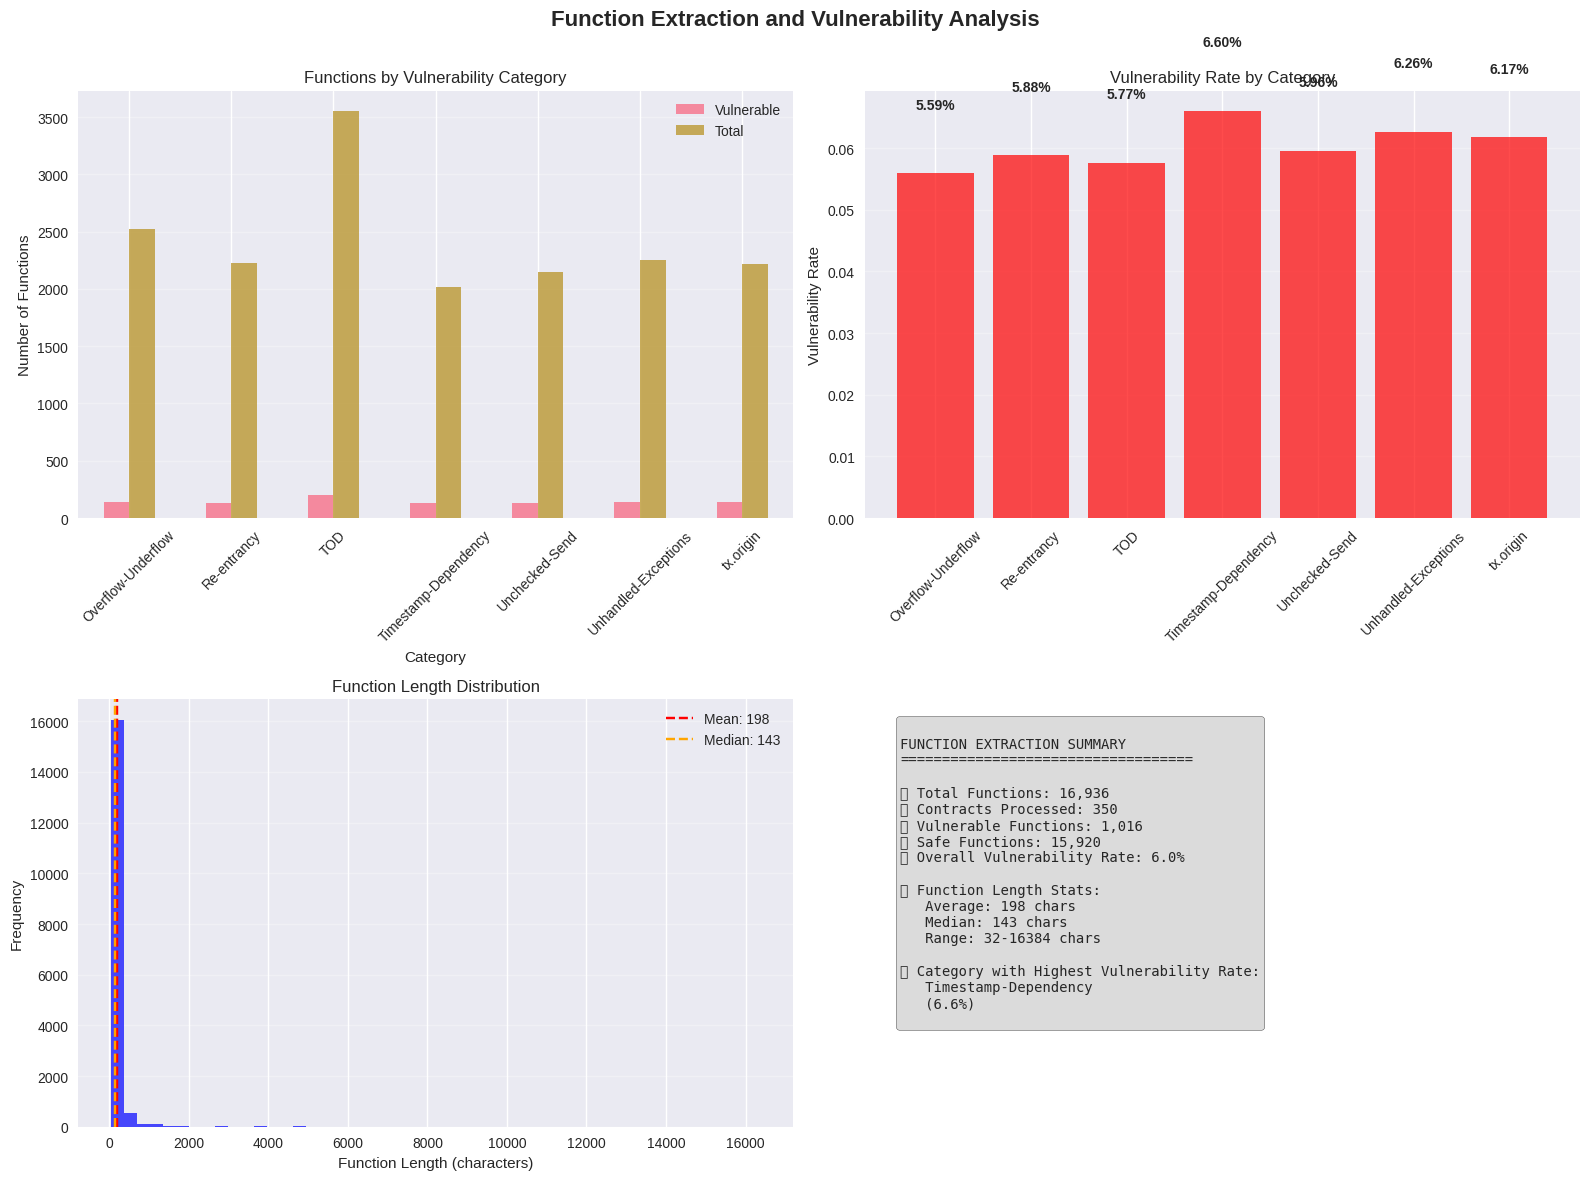

💾 Function analysis visualization saved to ../results/visualizations/function_analysis.png


In [8]:
# Create visualizations
# Ensure visualization directory exists
Path('../results/visualizations').mkdir(parents=True, exist_ok=True)

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Function Extraction and Vulnerability Analysis', fontsize=16, fontweight='bold')

# 1. Functions by category
vuln_by_category.plot(x='Category', y=['Vulnerable_Functions', 'Total_Functions'], 
                      kind='bar', ax=ax1, alpha=0.8)
ax1.set_title('Functions by Vulnerability Category')
ax1.set_ylabel('Number of Functions')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(['Vulnerable', 'Total'])
ax1.grid(axis='y', alpha=0.3)

# 2. Vulnerability rate by category
bars2 = ax2.bar(vuln_by_category['Category'], vuln_by_category['Vulnerability_Rate'], 
                color='red', alpha=0.7)
ax2.set_title('Vulnerability Rate by Category')
ax2.set_ylabel('Vulnerability Rate')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, rate in zip(bars2, vuln_by_category['Vulnerability_Rate']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.2%}', ha='center', va='bottom', fontweight='bold')

# 3. Function length distribution
ax3.hist(functions_df['length'], bins=50, alpha=0.7, color='blue')
ax3.axvline(functions_df['length'].mean(), color='red', linestyle='--', 
            label=f'Mean: {functions_df["length"].mean():.0f}')
ax3.axvline(functions_df['length'].median(), color='orange', linestyle='--', 
            label=f'Median: {functions_df["length"].median():.0f}')
ax3.set_title('Function Length Distribution')
ax3.set_xlabel('Function Length (characters)')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Summary statistics
ax4.axis('off')
summary_text = f"""
FUNCTION EXTRACTION SUMMARY
{'='*35}

📊 Total Functions: {len(functions_df):,}
📄 Contracts Processed: {stats['successful_contracts']}
💥 Vulnerable Functions: {stats['vulnerable_functions']:,}
✅ Safe Functions: {stats['safe_functions']:,}
📈 Overall Vulnerability Rate: {stats['vulnerable_functions']/stats['total_functions']:.1%}

📏 Function Length Stats:
   Average: {functions_df['length'].mean():.0f} chars
   Median: {functions_df['length'].median():.0f} chars
   Range: {functions_df['length'].min()}-{functions_df['length'].max()} chars

🎯 Category with Highest Vulnerability Rate:
   {vuln_by_category.loc[vuln_by_category['Vulnerability_Rate'].idxmax(), 'Category']}
   ({vuln_by_category['Vulnerability_Rate'].max():.1%})
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10, 
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig('../results/visualizations/function_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Function analysis visualization saved to ../results/visualizations/function_analysis.png")

## 8. Create Labeled Dataset

In [9]:
# Create clean labeled dataset for machine learning
print("🏷️ CREATING LABELED DATASET")
print("=" * 40)

# Prepare dataset
dataset = []

for func in all_functions:
    # Skip functions that are too short or too long
    if len(func['code']) < 50 or len(func['code']) > 10000:
        continue
    
    # Create dataset entry
    entry = {
        'function_name': func['name'],
        'code': func['code'],
        'is_vulnerable': func['is_vulnerable'],
        'vulnerability_category': func['vulnerability_category'],
        'vulnerability_types': '|'.join(func['vulnerability_types']) if func['vulnerability_types'] else '',
        'contract_file': func['contract_file'],
        'function_type': func['type'],
        'code_length': len(func['code']),
        'num_bugs': len(func['bugs'])
    }
    
    dataset.append(entry)

# Convert to DataFrame
dataset_df = pd.DataFrame(dataset)

print(f"📊 Dataset Statistics:")
print(f"  Total functions: {len(dataset_df)}")
print(f"  Vulnerable: {dataset_df['is_vulnerable'].sum()}")
print(f"  Safe: {(~dataset_df['is_vulnerable']).sum()}")
print(f"  Balance ratio: {dataset_df['is_vulnerable'].mean():.1%}")

# Check class distribution by category
class_dist = dataset_df.groupby('vulnerability_category')['is_vulnerable'].agg(['count', 'sum', 'mean'])
class_dist.columns = ['Total', 'Vulnerable', 'Vulnerability_Rate']
print(f"\n📈 Class Distribution by Category:")
print(class_dist)

# Save the clean dataset
dataset_df.to_csv('../data/processed/function_dataset.csv', index=False)
print(f"\n💾 Dataset saved to ../data/processed/function_dataset.csv")

# Save processing statistics
with open('../data/processed/processing_stats.json', 'w') as f:
    json.dump(stats, f, indent=2)
print(f"💾 Processing stats saved to ../data/processed/processing_stats.json")

🏷️ CREATING LABELED DATASET
📊 Dataset Statistics:
  Total functions: 16720
  Vulnerable: 968
  Safe: 15752
  Balance ratio: 5.8%

📈 Class Distribution by Category:
                        Total  Vulnerable  Vulnerability_Rate
vulnerability_category                                       
Overflow-Underflow       2490         136            0.054618
Re-entrancy              2195         126            0.057403
TOD                      3523         198            0.056202
Timestamp-Dependency     1983         125            0.063036
Unchecked-Send           2120         120            0.056604
Unhandled-Exceptions     2221         134            0.060333
tx.origin                2188         129            0.058958

💾 Dataset saved to ../data/processed/function_dataset.csv
💾 Processing stats saved to ../data/processed/processing_stats.json


## 9. Create Train/Validation Split

In [10]:
# Create stratified train/validation split
print("📊 CREATING TRAIN/VALIDATION SPLIT")
print("=" * 40)

# Stratify by both vulnerability status and category
dataset_df['stratify_key'] = dataset_df['vulnerability_category'] + '_' + dataset_df['is_vulnerable'].astype(str)

# Split dataset
train_df, val_df = train_test_split(
    dataset_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=dataset_df['stratify_key']
)

# Remove temporary column
train_df = train_df.drop('stratify_key', axis=1)
val_df = val_df.drop('stratify_key', axis=1)

print(f"📊 Split Statistics:")
print(f"  Training set: {len(train_df)} functions")
print(f"    - Vulnerable: {train_df['is_vulnerable'].sum()} ({train_df['is_vulnerable'].mean():.1%})")
print(f"    - Safe: {(~train_df['is_vulnerable']).sum()} ({(~train_df['is_vulnerable']).mean():.1%})")

print(f"  Validation set: {len(val_df)} functions")
print(f"    - Vulnerable: {val_df['is_vulnerable'].sum()} ({val_df['is_vulnerable'].mean():.1%})")
print(f"    - Safe: {(~val_df['is_vulnerable']).sum()} ({(~val_df['is_vulnerable']).mean():.1%})")

# Check distribution across categories
print(f"\n📈 Category Distribution:")
train_cat_dist = train_df['vulnerability_category'].value_counts().sort_index()
val_cat_dist = val_df['vulnerability_category'].value_counts().sort_index()

dist_comparison = pd.DataFrame({
    'Train': train_cat_dist,
    'Validation': val_cat_dist,
    'Train_Pct': train_cat_dist / len(train_df) * 100,
    'Val_Pct': val_cat_dist / len(val_df) * 100
})
print(dist_comparison)

# Save splits
train_df.to_csv('../data/processed/train_functions.csv', index=False)
val_df.to_csv('../data/processed/validation_functions.csv', index=False)

print(f"\n💾 Training set saved to ../data/processed/train_functions.csv")
print(f"💾 Validation set saved to ../data/processed/validation_functions.csv")

📊 CREATING TRAIN/VALIDATION SPLIT
📊 Split Statistics:
  Training set: 13376 functions
    - Vulnerable: 774 (5.8%)
    - Safe: 12602 (94.2%)
  Validation set: 3344 functions
    - Vulnerable: 194 (5.8%)
    - Safe: 3150 (94.2%)

📈 Category Distribution:
                        Train  Validation  Train_Pct    Val_Pct
vulnerability_category                                         
Overflow-Underflow       1992         498  14.892344  14.892344
Re-entrancy              1756         439  13.127990  13.127990
TOD                      2818         705  21.067584  21.082536
Timestamp-Dependency     1587         396  11.864533  11.842105
Unchecked-Send           1696         424  12.679426  12.679426
Unhandled-Exceptions     1777         444  13.284988  13.277512
tx.origin                1750         438  13.083134  13.098086

💾 Training set saved to ../data/processed/train_functions.csv
💾 Validation set saved to ../data/processed/validation_functions.csv


## 10. Sample Data Inspection

In [11]:
# Inspect sample functions from the dataset
print("🔍 SAMPLE DATA INSPECTION")
print("=" * 40)

# Show sample vulnerable function
vulnerable_samples = train_df[train_df['is_vulnerable'] == True].head(1)
if len(vulnerable_samples) > 0:
    vuln_sample = vulnerable_samples.iloc[0]
    print(f"💥 VULNERABLE FUNCTION SAMPLE:")
    print(f"  Function: {vuln_sample['function_name']}")
    print(f"  Category: {vuln_sample['vulnerability_category']}")
    print(f"  Bug types: {vuln_sample['vulnerability_types']}")
    print(f"  Length: {vuln_sample['code_length']} characters")
    print(f"  Code preview:")
    print(f"  {'-' * 50}")
    print(vuln_sample['code'][:500] + "..." if len(vuln_sample['code']) > 500 else vuln_sample['code'])
    print(f"  {'-' * 50}")

# Show sample safe function
safe_samples = train_df[train_df['is_vulnerable'] == False].head(1)
if len(safe_samples) > 0:
    safe_sample = safe_samples.iloc[0]
    print(f"\n✅ SAFE FUNCTION SAMPLE:")
    print(f"  Function: {safe_sample['function_name']}")
    print(f"  Category: {safe_sample['vulnerability_category']}")
    print(f"  Length: {safe_sample['code_length']} characters")
    print(f"  Code preview:")
    print(f"  {'-' * 50}")
    print(safe_sample['code'][:500] + "..." if len(safe_sample['code']) > 500 else safe_sample['code'])
    print(f"  {'-' * 50}")

# Show dataset summary statistics
print(f"\n📊 DATASET SUMMARY STATISTICS")
print(f"{'-' * 40}")
print(f"Code length statistics:")
print(dataset_df['code_length'].describe())

print(f"\nFunction name diversity: {dataset_df['function_name'].nunique()} unique names")
print(f"Contract diversity: {dataset_df['contract_file'].nunique()} unique contracts")
print(f"Category diversity: {dataset_df['vulnerability_category'].nunique()} categories")

🔍 SAMPLE DATA INSPECTION
💥 VULNERABLE FUNCTION SAMPLE:
  Function: mul
  Category: Re-entrancy
  Bug types: Re+AC0-erntrancy
  Length: 146 characters
  Code preview:
  --------------------------------------------------
function mul(uint256 a, uint256 b) internal pure returns (uint256) {
if (a == 0) {
return 0;
}
uint256 c = a * b;
require(c / a == b);
return c;
}
  --------------------------------------------------

✅ SAFE FUNCTION SAMPLE:
  Function: getReward_TOD29
  Category: TOD
  Length: 78 characters
  Code preview:
  --------------------------------------------------
function getReward_TOD29() payable public{
winner_TOD29.transfer(msg.value);
}
  --------------------------------------------------

📊 DATASET SUMMARY STATISTICS
----------------------------------------
Code length statistics:
count    16720.000000
mean       190.270096
std        375.331495
min         51.000000
25%         95.000000
50%        143.000000
75%        179.000000
max       9313.000000
Name: code_lengt

## 11. Final Summary and Next Steps

In [12]:
# Create final summary
print("🎯 PREPROCESSING AND FUNCTION EXTRACTION COMPLETE!")
print("=" * 60)

summary = f"""
📊 PROCESSING SUMMARY:
• {stats['successful_contracts']} contracts processed successfully
• {stats['total_functions']} functions extracted
• {stats['vulnerable_functions']} vulnerable functions identified
• {stats['safe_functions']} safe functions identified
• {len(dataset_df)} functions in final dataset

📈 DATASET CHARACTERISTICS:
• Vulnerability rate: {dataset_df['is_vulnerable'].mean():.1%}
• Average function length: {dataset_df['code_length'].mean():.0f} characters
• Function length range: {dataset_df['code_length'].min()}-{dataset_df['code_length'].max()} characters
• Training set size: {len(train_df)} functions
• Validation set size: {len(val_df)} functions

🎯 VULNERABILITY CATEGORIES:
• {', '.join(vulnerability_categories)}

🚀 READY FOR NEXT STEPS:
• CodeBERT tokenization and encoding
• Dataset optimization for transformer models
• Model training pipeline setup
• Fine-tuning and evaluation

📁 GENERATED FILES:
• function_dataset.csv - Complete labeled dataset
• train_functions.csv - Training split
• validation_functions.csv - Validation split
• processing_stats.json - Processing statistics
• function_analysis.png - Analysis visualizations

✨ QUALITY INDICATORS:
• Balanced representation across vulnerability categories
• Clean, parsed function code ready for tokenization
• Proper train/validation stratification
• Bug locations mapped to specific functions
• Ready for transformer-based training
"""

print(summary)

# Save summary
Path('../outputs').mkdir(exist_ok=True)
with open('../outputs/preprocessing_summary.txt', 'w') as f:
    f.write(summary)

print("💾 Summary saved to ../outputs/preprocessing_summary.txt")
print("\n🎯 Ready to proceed to notebook 03: Tokenization and Dataset Creation!")

# Display key metrics for next steps
print(f"\n📋 KEY METRICS FOR NEXT NOTEBOOK:")
print(f"  • Functions ready for tokenization: {len(dataset_df):,}")
print(f"  • Training functions: {len(train_df):,}")
print(f"  • Validation functions: {len(val_df):,}")
print(f"  • Average sequence length: {dataset_df['code_length'].mean():.0f} chars")
print(f"  • Max sequence length: {dataset_df['code_length'].max()} chars")
print(f"  • Class balance: {dataset_df['is_vulnerable'].mean():.1%} vulnerable")

🎯 PREPROCESSING AND FUNCTION EXTRACTION COMPLETE!

📊 PROCESSING SUMMARY:
• 350 contracts processed successfully
• 16936 functions extracted
• 1016 vulnerable functions identified
• 15920 safe functions identified
• 16720 functions in final dataset

📈 DATASET CHARACTERISTICS:
• Vulnerability rate: 5.8%
• Average function length: 190 characters
• Function length range: 51-9313 characters
• Training set size: 13376 functions
• Validation set size: 3344 functions

🎯 VULNERABILITY CATEGORIES:
• TOD, Unhandled-Exceptions, Overflow-Underflow, Unchecked-Send, Timestamp-Dependency, tx.origin, Re-entrancy

🚀 READY FOR NEXT STEPS:
• CodeBERT tokenization and encoding
• Dataset optimization for transformer models
• Model training pipeline setup
• Fine-tuning and evaluation

📁 GENERATED FILES:
• function_dataset.csv - Complete labeled dataset
• train_functions.csv - Training split
• validation_functions.csv - Validation split
• processing_stats.json - Processing statistics
• function_analysis.png -